<img src="../logo_skmob.png" width=250 align="left"/>

# Human Mobility Measures

we can compute on a `TrajDataFrame` two types of measures:

- **individual measures**, describing features related to the mobility patterns of a single individual
- **collective measures**, describing the mobility patterns of an entire population of individuals

In [1]:
# let's import some useful libraries
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import pandas as pd
from stats_utils import *
from tqdm import tqdm
import folium
from folium.plugins import HeatMap

In [2]:
# let's import skmob's data structures
import skmob
from skmob import TrajDataFrame, FlowDataFrame

## Loading the data
- We load data of *checkins* made by users on **Brightkite**
- Brightkite is a location-based social network (LBSN)
- The dataset is freely available at the SNAP website: https://snap.stanford.edu/data/loc-brightkite.html

In [3]:
# we download the d ataset using pandas
url = "https://snap.stanford.edu/data/loc-brightkite_totalCheckins.txt.gz"
df = pd.read_csv(url, sep='\t', header=0, nrows=500000, 
                 names=['user', 'check-in_time', 
                        "latitude", "longitude", 
                        "location id"])

# we convert the pandas DataFrame into an skmob TrajDataFrame
tdf = skmob.TrajDataFrame(df, latitude='latitude', 
                          longitude='longitude', 
                          datetime='check-in_time',
                          user_id='user')
tdf.head()

,uid,datetime,lat,lng,location id
0,0,2010-10-16 06:02:04+00:00,39.891383,-105.070814,7a0f88982aa015062b95e3b4843f9ca2
1,0,2010-10-16 03:48:54+00:00,39.891077,-105.068532,dd7cd3d264c2d063832db506fba8bf79
2,0,2010-10-14 18:25:51+00:00,39.750469,-104.999073,9848afcc62e500a01cf6fbf24b797732f8963683
3,0,2010-10-14 00:21:47+00:00,39.752713,-104.996337,2ef143e12038c870038df53e0478cefc
4,0,2010-10-13 23:31:51+00:00,39.752508,-104.996637,424eb3dd143292f9e013efa00486c907


In [4]:
print("number of users:\t", len(tdf.uid.unique()))
print("number of records:\t", len(tdf))

number of users:	 1231
number of records:	 500000


# Individual measures

- are computed on the trajectories of a <u>single individual</u>
- quantify standard *mobility patterns*
- examples: 
    - length of displacements
    - charateristic distance
    - visitation frequency
    - predictability of an individual

## Jump lengths
- a jump length is is the distance between two consecutive visits of an individual
- given a `TrajDataFrame`, skmob computes the lengths for each individual independently
- use the `jump_lengths` function

In [5]:
from skmob.measures.individual import jump_lengths

In [6]:
# to disable the progress bar, show_progress=False
jl_df = jump_lengths(tdf)
jl_df.head()

100%|██████████| 1231/1231 [00:05<00:00, 215.38it/s]


,uid,jump_lengths
0,0,"[19.640467328877936, 0.0, 0.0, 1.7434311010381..."
1,1,"[6.505330424378251, 46.75436600375988, 53.9284..."
2,2,"[0.0, 0.0, 0.0, 0.0, 3.6410097195943507, 0.0, ..."
3,3,"[3861.2706300798827, 4.061631313492122, 5.9163..."
4,4,"[15511.92758595804, 0.0, 15511.92758595804, 1...."


In [7]:
# merge=True put all distances of the individuals into a single list
jl_list = jump_lengths(tdf, merge=True)
type(jl_list)

100%|██████████| 1231/1231 [00:06<00:00, 198.79it/s]


list

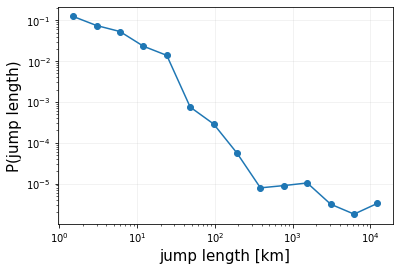

In [8]:
# let's plot the distribution of jump lengths
fig = plt.figure()
x, y = zip(*lbpdf(2.0, [dist for dist in jl_list[:10000] if dist >= 1]))
plt.plot(x, y, marker='o')
plt.grid(alpha=0.2) 
plt.xlabel('jump length [km]', fontsize=15)
plt.ylabel('P(jump length)', fontsize=15)
plt.loglog()
plt.show()

### Other types of distances

- maximum distance traveled by each individual `maximum_distance`
- sum of distances of an individual `distance_straight_line`
- maximum distance traved by an individual for their home `max_distance_from_home`

In [9]:
from skmob.measures.individual import max_distance_from_home, distance_straight_line, maximum_distance

In [10]:
md_df = maximum_distance(tdf)

100%|██████████| 1231/1231 [00:05<00:00, 209.92it/s]


In [14]:
sld_df = distance_straight_line(tdf)

100%|██████████| 1231/1231 [00:05<00:00, 237.40it/s]


In [11]:
mdh_df = max_distance_from_home(tdf)
mdh_df.head()

100%|██████████| 1231/1231 [00:30<00:00, 40.03it/s]


,uid,max_distance_from_home
0,0,11286.942949
1,1,12800.547682
2,2,11282.748348
3,3,12799.754644
4,4,15512.788707


/home/lucpappalard/miniconda3/envs/skmob/lib/python3.7/site-packages/numpy-1.16.3-py3.7-linux-x86_64.egg/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/lucpappalard/miniconda3/envs/skmob/lib/python3.7/site-packages/numpy-1.16.3-py3.7-linux-x86_64.egg/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


NameError: name 'sld_df' is not defined

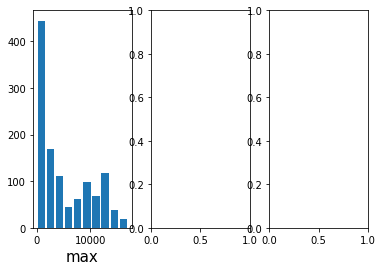

In [12]:
# let's plot the distribution of those three measures
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(md_df.maximum_distance, bins=10, rwidth=0.8)
ax1.set_xlabel('max', fontsize=15)
x, y = zip(*lbpdf(2.0, list(sld_df.distance_straight_line)))
ax2.plot(x, y, marker='o')
ax2.loglog()
ax2.set_xlabel('straight', fontsize=15)
ax3.hist(mdh_df.max_distance_from_home, bins=10, rwidth=0.8)
ax3.set_xlabel('from home', fontsize=15)
plt.show()

## Radius of gyration $r_g$
characteristic distance traveled by an individual:

$$r_g = \sqrt{\frac{1}{N} \sum_{i=1}^N (\mathbf{r}_i - \mathbf{r}_{cm})^2}$$

$r_{cm}$ is the position vector of the *center of mass* of the set of locations visited by the individual

In [18]:
from skmob.measures.individual import radius_of_gyration

In [19]:
rg_df = radius_of_gyration(tdf)
rg_df.head()

100%|██████████| 1231/1231 [00:03<00:00, 317.24it/s]


,uid,radius_of_gyration
0,0,1564.436792
1,1,2467.773523
2,2,1439.649774
3,3,1752.604191
4,4,5380.503250


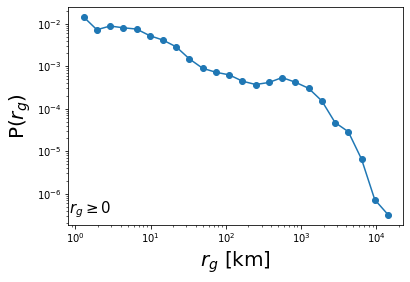

In [20]:
# let's plot the distribution of the radius of gyration
fig = plt.figure()
x, y = zip(*lbpdf(1.5, list(rg_df.radius_of_gyration[rg_df.radius_of_gyration >= 1.0])))
plt.plot(x, y, marker='o')
plt.xlabel('$r_g$ [km]', fontsize=20)
plt.ylabel('P($r_g$)', fontsize=20)
plt.loglog()
plt.text(0.15, 0.15, '$r_g \geq 0$', transform=ax1.transAxes, fontsize=15)
plt.show()

## $k$-radius of gyration $r_g^{(k)}$
influence of frequency of location visits on the radius of gyration:
$$ r_g^{(k)} = \sqrt{\frac{1}{N_k} \sum_{i=1}^{k} n_i (\mathbf{r}_i - \mathbf{r}_{cm}^{(k)})} $$

$k$ indicates the number of recurrent locations to consider

In [21]:
from skmob.measures.individual import k_radius_of_gyration

In [22]:
# compute the 3-radius of each individual
krg_df = k_radius_of_gyration(tdf, k=3)
krg_df.head()

100%|██████████| 1231/1231 [00:11<00:00, 108.91it/s]


,uid,3k_radius_of_gyration
0,0,7.730516
1,1,3.620671
2,2,6.366549
3,3,10.543072
4,4,3910.808802


In [23]:
rg_krg_df = pd.merge(rg_df, krg_df, on='uid')
rg_krg_df.head()

,uid,radius_of_gyration,3k_radius_of_gyration
0,0,1564.436792,7.730516
1,1,2467.773523,3.620671
2,2,1439.649774,6.366549
3,3,1752.604191,10.543072
4,4,5380.503250,3910.808802


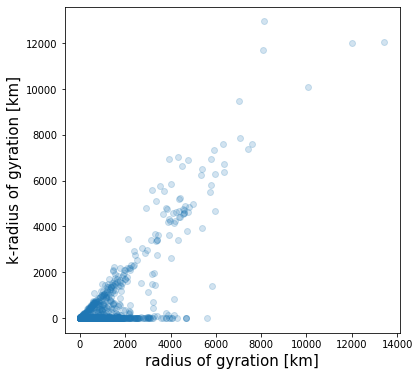

In [24]:
# let's plot a scatter plot of r_g vs r_g^{(k)}
fig = plt.figure(figsize=(6, 6))
plt.scatter(rg_krg_df.radius_of_gyration, rg_krg_df['3k_radius_of_gyration'], alpha=0.2)
plt.xlabel('radius of gyration [km]', fontsize=15)
plt.ylabel('k-radius of gyration [km]', fontsize=15)
plt.show()

## Mobility Entropy
degree of <u>predictability</u> of an individual's mobility:
- random entropy - `random_entropy`
- temporal uncorrelated entropy - `uncorrelated_entropy`
- real entropy - `real_entropy`

### Random entropy $S_{rand}(u)$
predictability of $u$ if each location is visited with equal probability

In [25]:
from skmob.measures.individual import random_entropy

In [26]:
e_df = random_entropy(tdf)
e_df.head()

100%|██████████| 1231/1231 [00:07<00:00, 161.17it/s]


,uid,random_entropy
0,0,9.082149
1,1,6.599913
2,2,8.845490
3,3,9.262095
4,4,7.754888


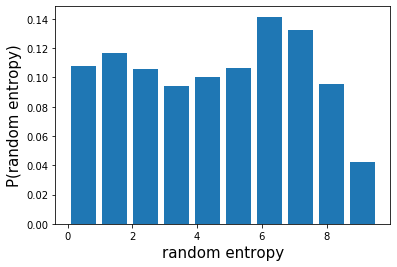

In [27]:
fig = plt.figure()
plt.hist(e_df.random_entropy, bins=10, rwidth=0.8, density=True)
plt.xlabel('random entropy', fontsize=15)
plt.ylabel('P(random entropy)', fontsize=15)
plt.show()

### Temporal-uncorrelated entropy $S_{unc}(u)$
historical probability that a location $i$ was visited by $u$

$$S_{unc}(u) = - \sum_{i=1}^n p_i \log_2 p_i$$

$n$ is the number of location visited by $u$

In [28]:
from skmob.measures.individual import uncorrelated_entropy

In [29]:
# if normalize=True the entropy is in the range [0, 1 ] 
nue_df = uncorrelated_entropy(tdf, normalize=True)
nue_df.head()

100%|██████████| 1231/1231 [00:08<00:00, 138.03it/s]


,uid,norm_uncorrelated_entropy
0,0,0.819430
1,1,0.552972
2,2,0.764304
3,3,0.794553
4,4,0.756421


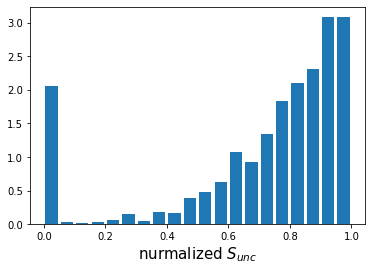

In [30]:
fig = plt.figure()
plt.hist(nue_df.norm_uncorrelated_entropy, bins=20, rwidth=0.8, density=True)
plt.xlabel('nurmalized $S_{unc}$', fontsize=15)
plt.show()

### Real entropy $S(u)$
consider the order in which the nodes were visited and the time spent at each location

$$ S(u) = - \sum_{T'_i \subset T_i} p_{T'_i} \log_2 p_{T'_i}$$

captures the full spatiotemporal order present in $u$'s mobility patterns

In [31]:
from skmob.measures.individual import real_entropy

In [32]:
re_df = real_entropy(tdf[tdf.uid < 50])
re_df.head()

100%|██████████| 50/50 [01:00<00:00,  1.05it/s]


,uid,real_entropy
0,0,4.906479
1,1,2.207224
2,2,4.467225
3,3,4.782442
4,4,3.585371


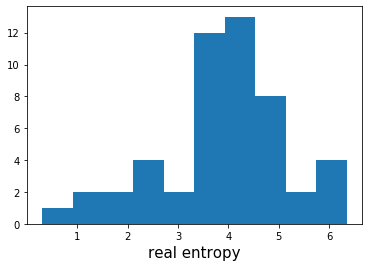

In [43]:
plt.hist(re_df.real_entropy)
plt.xlabel('real entropy', fontsize=15)
plt.show()

### Number of locations and visits
number of distinct locations visited and the number of movements

In [44]:
from skmob.measures.individual import number_of_visits, number_of_locations

In [45]:
nv_df = number_of_visits(tdf)
locs_df = number_of_locations(tdf)
nv_df.head()

100%|██████████| 1231/1231 [00:07<00:00, 164.38it/s]


,uid,number_of_visits
0,0,2099
1,1,1210
2,2,2100
3,3,1807
4,4,779


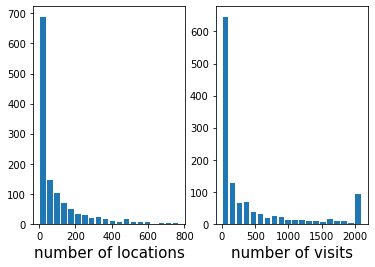

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(locs_df.number_of_locations, rwidth=0.8, bins=20)
ax1.set_xlabel('number of locations', fontsize=15)
ax2.hist(nv_df.number_of_visits, rwidth=0.8, bins=20)
ax2.set_xlabel('number of visits', fontsize=15)
plt.show()

### Home location
the location the individual visits most frequently during nighttime

In [13]:
from skmob.measures.individual import home_location

In [14]:
hl_df = home_location(tdf)
hl_df.head()

100%|██████████| 1231/1231 [00:06<00:00, 198.77it/s]


,uid,lat,lng
0,0,39.891077,-105.068532
1,1,37.630490,-122.411084
2,2,39.739154,-104.984703
3,3,37.748170,-122.459192
4,4,60.180171,24.949728


In [15]:
m = folium.Map(tiles = 'openstreetmap', zoom_start=10, control_scale=True)
HeatMap(hl_df[['lat', 'lng']].values).add_to(m)
m # Show map

## Visitation frequency
the number of visits to each location, where locations are sorted by rank
- the most visited location has rank 1, the second most visited rank 2, etc.
- the two most visited locations are generally home and work

In [51]:
from skmob.measures.individual import location_frequency
lf_df = location_frequency(tdf, normalize=False).reset_index()
lf_df.head()

100%|██████████| 1231/1231 [00:04<00:00, 282.84it/s]


,uid,lat,lng,location_frequency
0,0,39.762146,-104.982480,214
1,0,39.891077,-105.068532,137
2,0,39.739154,-104.984703,126
3,0,39.891586,-105.068463,72
4,0,39.827022,-105.143191,53


In [52]:
ranks = location_frequency(tdf, as_ranks=True)
ranks[:5]

100%|██████████| 1231/1231 [00:04<00:00, 263.52it/s]


[0.3855048033663369,
 0.14812392490535803,
 0.07861157993382727,
 0.053773415913195455,
 0.04063414740693758]

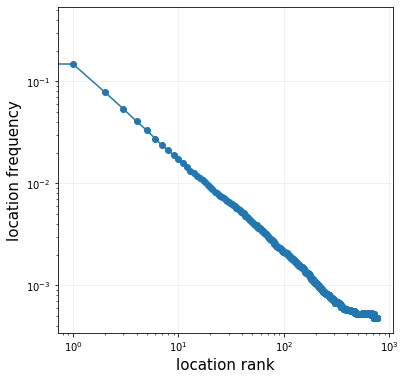

In [53]:
fig = plt.figure(figsize=(6, 6))
plt.plot(range(len(ranks)), ranks, marker='o')
plt.loglog()
plt.xlabel('location rank', fontsize=15)
plt.ylabel('location frequency', fontsize=15)
plt.grid(alpha=0.2)
plt.show()

## Frequency and Recency ranks
Given a location:
- its frequency rank is 1 if it is the most frequent location, 2 if it is the second most visited, etc.
- its recency rank is 1 if it is the last visited location, 2 if it is the second last visited, etc.

In [54]:
from skmob.measures.individual import frequency_rank, recency_rank

In [60]:
fr_df = frequency_rank(tdf)#.reset_index().drop('level_1', axis=1)
fr_df.head()

100%|██████████| 1231/1231 [00:06<00:00, 175.95it/s]


lat         lng  frequency_rank
uid                                         
0   0  39.762146 -104.982480               1
    1  39.891077 -105.068532               2
    2  39.739154 -104.984703               3
    3  39.891586 -105.068463               4
    4  39.827022 -105.143191               5

In [61]:
rr_df = recency_rank(tdf)#.reset_index().drop('level_1', axis=1)
rr_df.head()

100%|██████████| 1231/1231 [00:05<00:00, 210.16it/s]


lat         lng  recency_rank
uid                                       
0   0  39.891383 -105.070814             1
    1  39.891077 -105.068532             2
    2  39.750469 -104.999073             3
    3  39.752713 -104.996337             4
    4  39.752508 -104.996637             5

In [64]:
merged_df = pd.merge(fr_df, rr_df, on=['uid', 'lat', 'lng'])
short_merged_df = merged_df[(merged_df.frequency_rank <= 50) 
                            & (merged_df.recency_rank <= 50)]

# Calculate the point density
n_rows = 100000
xy = np.vstack([short_merged_df.frequency_rank.head(n_rows), short_merged_df.recency_rank.head(n_rows)])
z = gaussian_kde(xy)(xy)

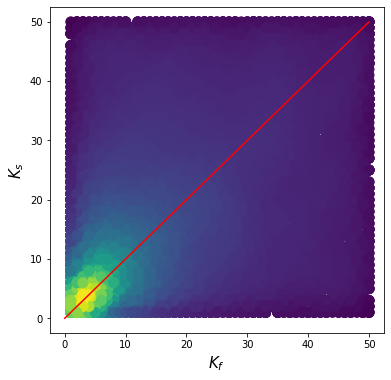

In [68]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(short_merged_df.frequency_rank.head(n_rows), short_merged_df.recency_rank.head(n_rows), c=z, s=100)
ax.plot([0, 50], [0, 50], color='r')
ax.set_xlabel('$K_f$', fontsize=15)
ax.set_ylabel('$K_s$', fontsize=15)
plt.show()

## Waiting times
- a waiting time is the time (in seconds) between the visits to two successive locations
- given a `TrajDataFrame`, skmob computes the waiting times for each individual independently
- use the `waiting_times` function

In [69]:
from skmob.measures.individual import waiting_times

In [70]:
wt_df = waiting_times(tdf)
wt_df.head()

100%|██████████| 1231/1231 [00:02<00:00, 467.44it/s]


,uid,waiting_times
0,0,"[2358.0, 136.0, 303.0, 1836.0, 14869.0, 517.0,..."
1,1,"[43460.0, 34353.0, 8347.0, 40694.0, 281.0, 16...."
2,2,"[293.0, 308.0, 228.0, 402.0, 16086.0, 665.0, 9..."
3,3,"[10200079.0, 30864.0, 54415.0, 2135.0, 63.0, 1..."
4,4,"[82845.0, 56.0, 415156.0, 1372.0, 23.0, 42679...."


In [71]:
wl_list = waiting_times(tdf, merge=True)
len(wl_list)

100%|██████████| 1231/1231 [00:02<00:00, 470.39it/s]


498769

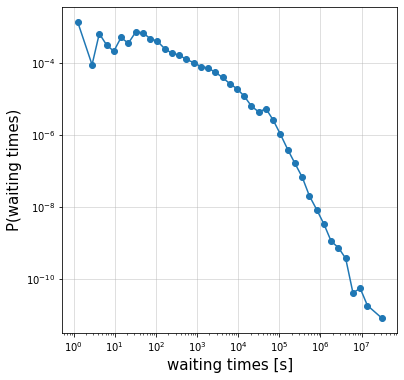

In [72]:
fig = plt.figure(figsize=(6, 6))
x, y = zip(*lbpdf(1.5, wl_list[:10000]))
plt.plot(x, y, marker='o')
plt.grid(alpha=0.5)
plt.xlabel('waiting times [s]', fontsize=15)
plt.ylabel('P(waiting times)', fontsize=15)
plt.loglog()
plt.show()

## Individual mobility network
a network where: 
- nodes represent locations visited by the individual
- directed edges represent trips between the locations made by the individual 

In [16]:
from skmob.measures.individual import individual_mobility_network

In [17]:
imn_df = individual_mobility_network(tdf)
imn_df.head()

100%|██████████| 1231/1231 [00:06<00:00, 195.82it/s]


,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
0,0,37.774929,-122.419415,37.600747,-122.382376,1
1,0,37.600747,-122.382376,37.615223,-122.389979,1
2,0,37.600747,-122.382376,37.580304,-122.343679,1
3,0,37.615223,-122.389979,39.878664,-104.682105,1
4,0,37.615223,-122.389979,37.580304,-122.343679,1


In [75]:
an_imn = imn_df[imn_df.uid == 2]
an_imn.head()

,uid,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
1397,2,39.746397,-104.959766,39.750729,-104.917552,1
1398,2,39.746397,-104.959766,39.711161,-104.934527,1
1399,2,39.746397,-104.959766,39.825947,-105.145944,1
1400,2,39.746397,-104.959766,39.739154,-104.984703,1
1401,2,39.746397,-104.959766,39.785470,-104.895895,1


# Collective measures

- are computed on the trajectories of a <u>population of individuals</u>
- quantify standard *mobility patterns*
- examples: 
    - location entropy
    - origin destination matrix
    - visits per time unit

## Homes per location
number of homes per location (uses `home_location`)

In [76]:
from skmob.measures.collective import homes_per_location

In [78]:
hl_df = homes_per_location(tdf, start_night='20:00')
hl_df.head()

100%|██████████| 1231/1231 [00:05<00:00, 218.12it/s]


,lat,lng,n_homes
0,39.739154,-104.984703,70
1,37.774929,-122.419415,37
2,40.014986,-105.270546,31
3,0.000000,0.000000,27
4,30.267153,-97.743061,15


In [79]:
m = folium.Map(tiles = 'openstreetmap', zoom_start=10, control_scale=True)
HeatMap(hl_df[['lat', 'lng']].values).add_to(m)
m

## Uncorrelated location entropy

historical probability that an individual $u$ visits location $i$

$$S_{unc}^{loc}(i) = - \sum_{j=u}^m p_j \log_2 p_j$$

$m$ is the number of useres that visited location $i$

In [80]:
from skmob.measures.collective import uncorrelated_location_entropy

In [81]:
ule_df = uncorrelated_location_entropy(tdf, show_progress=True)
ule_df.head()

100%|██████████| 77917/77917 [01:15<00:00, 1038.57it/s]


,lat,lng,uncorrelated_location_entropy
0,-94.578567,39.099727,0.0
1,-90.000000,0.000000,0.0
2,-75.250973,-0.071389,0.0
3,-70.683333,-44.316667,0.0
4,-45.032284,168.660278,0.0


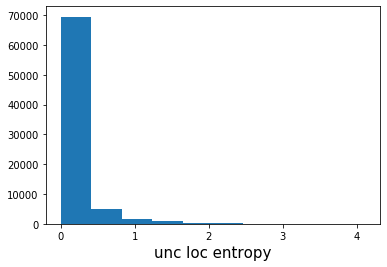

In [82]:
fig = plt.figure()
plt.hist(ule_df.uncorrelated_location_entropy)
plt.xlabel('unc loc entropy', fontsize=15)
plt.show()

## Visits per location

number of visits to a location made by the population of individuals

In [83]:
from skmob.measures.collective import visits_per_location

In [84]:
vpl_df = visits_per_location(tdf)
vpl_df.head()

,lat,lng,n_visits
0,0.000000,0.000000,10378
1,39.739154,-104.984703,9958
2,40.014986,-105.270546,4548
3,37.774929,-122.419415,3615
4,40.714269,-74.005973,2881


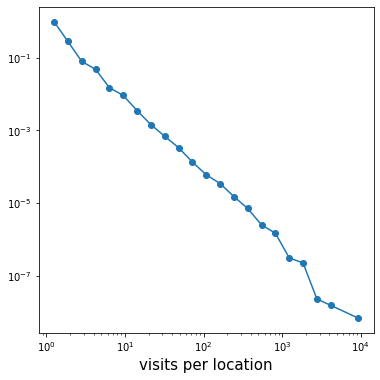

In [86]:
fig = plt.figure(figsize=(6, 6))
x, y = zip(*lbpdf(1.5, list(vpl_df.n_visits)))
plt.plot(x, y, marker='o')
plt.xlabel('visits per location', fontsize=15)
plt.loglog()
plt.show()

## Visits per time unit

number of visits of the population of individuals in a time slot (default: 1 hour)


In [87]:
from skmob.measures.collective import visits_per_time_unit

In [88]:
vtu_df = visits_per_time_unit(tdf)
vtu_df.head()

,n_visits
datetime,
2008-03-22 05:00:00+00:00,2
2008-03-22 06:00:00+00:00,2
2008-03-22 07:00:00+00:00,0
2008-03-22 08:00:00+00:00,0
2008-03-22 09:00:00+00:00,0


/home/lucpappalard/miniconda3/envs/skmob/lib/python3.7/site-packages/pandas-0.24.2-py3.7-linux-x86_64.egg/pandas/core/arrays/datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


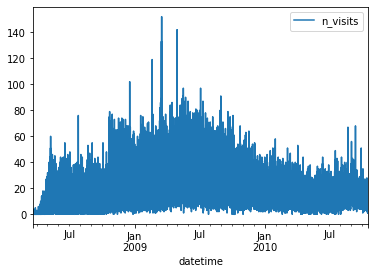

In [91]:
vtu_df.plot()
plt.show()

## Origin destination matrix

a network where: 
- nodes represent locations visited by the population of individuals
- directed edges represent trips between the locations made by the individuals

In [92]:
from skmob.measures.collective import origin_destination_matrix

In [93]:
od_df = origin_destination_matrix(tdf)
od_df.head()

100%|██████████| 1231/1231 [00:02<00:00, 449.37it/s]


,lat_origin,lng_origin,lat_dest,lng_dest,n_trips
0,37.774929,-122.419415,37.600747,-122.382376,3
1,37.774929,-122.419415,37.630490,-122.411084,8
2,37.774929,-122.419415,37.584103,-122.366083,55
3,37.774929,-122.419415,37.613825,-122.486919,2
4,37.774929,-122.419415,37.654656,-122.407750,12
